<a href="https://colab.research.google.com/github/kaluznys/uczenie_maszynowe_UW/blob/main/praca_domowa_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment – Adversarial Examples**

In this assignment, you will explore how small (invisible to humans) changes to real digits can _fool_ the CNN into misclassifying them, even though the changes are imperceptible to humans.



## Task 1 – CNN Dreams: Last Homework Assignment Revisited

Re-run the input optimization process (for NN dreams) from the previous MLP-class homework assignment, but this time using the **LeNet-5 CNN model** we trained in this class.


1. Starting from ten random noise images, optimize the input so that each image is classified with high confidence as one of the digits 0 through 9.
2. Include an **L2 penalty** on the input to keep the images visually closer to realistic digits. Use a range of penalty strengths (e.g., $\lambda_{l2}$ = 0, and then 0.01 through 10.0).
3. Compare the generated images (with and without L2 penalty) to those generated by the MLP:
   - Are they more or less readable?
   - Do they resemble real MNIST digits more closely or less?
   - Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.

Use `cross_entropy_loss + lambda_l2 * input.pow(2).mean()` as your objective.

Reuse your code: visualize confidence evolution during optimization and generate image grids and (optionally) animations showing how the inputs evolve.


## Task 2 – Adversarial Examples: Fooling LeNet-5

This is the core focus of the assignment.

Using a batch of **real MNIST digits** (e.g., nine examples per class), craft **adversarial examples** by adding subtle, trained noise to the input images. Your goal is to:

- **Keep the human-perceived digit the same** (e.g., a "7" should still look like a "7"),
- But **cause LeNet-5 to misclassify it** – as every other class different from the original, hence nine examples per class.

### Objective
For each image $x$ and its true label $y$, learn a perturbation $\delta$ such that:

- $\text{LeNet5}(x + \delta) = y_{\text{wrong}} $,
- and $ \|\delta\|_2 $ is as small as possible (penalize large perturbations), to keep $x + \delta$ *look* like $x$ for humans.

### Optimization
Use gradient-based optimization on $\delta$ (the noise), while keeping the network weights frozen. Your loss might look like:

```
loss = cross_entropy(model(x + delta), target_wrong_class) +
       lambda_l2 * delta.pow(2).mean()
```

Tune the $\lambda_{l2}$ to find the best range.

### Deliverables for the Second Task
- Select some best examples, showing the original digit and its (correct) classification and the perturbed digit (hopefully, still looking the same to humans) and how it gets misclassified. Show them side by side.
- Report:
  - Success rate of attacks (it doesn't need to be very formal),
  - Effect of $\lambda_{l2}$ on visibility of the noise and success of misclassification,
  - Example image grids and confidence plots.



## Deliverables for the Homework Assignment
- A Google Colab notebook with:
  - Complete implementation for both tasks.
  - Visualizations and animations (animations are optional but encouraged).
  - Clear written analysis of your findings.
- Upload the notebook and results to your GitHub repository for the course.
- Include a link to the notebook and video (if applicable) in the `README.md`.
- In the notebook, include “Open in Colab” badge so it can be launched directly.

In [17]:
import torch
import torchvision
from matplotlib import pyplot

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()

        # start tensors: 28x28x1
        # Convolutional layer 1: in_channels=1, out_channels=6, kernel_size=5
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        #tensor after: 28x28x6

        # Subsampling layer 1: 2x2 average pooling
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        #tensor after: 14x14x6

        # Convolutional layer 2: in_channels=6, out_channels=16, kernel_size=5
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        #tensor after: 10x10x16

        # Subsampling layer 2: 2x2 average pooling
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        #tensor after: 5x5x16

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # input from previous feature map
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))   # Conv1 + Tanh
        x = self.pool1(x)           # Pool1
        x = torch.sigmoid(self.conv2(x))   # Conv2 + Tanh
        x = self.pool2(x)           # Pool2
        x = x.view(-1, 16 * 5 * 5)  # Flatten
        x = torch.sigmoid(self.fc1(x))     # FC1 + Tanh
        x = torch.sigmoid(self.fc2(x))     # FC2 + Tanh
        x = self.fc3(x)             # Output layer (logits)
        x = self.dropout(x)
        return x

# Training Loop
----------------------

In [4]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = LeNet5().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(16):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the LeNet5 object. Please note,
                                            # the nonlinear activation after the last layer is NOT applied
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.3301198482513428
epoch: 0 batch: 1 current batch loss: 2.324777126312256
epoch: 0 batch: 2 current batch loss: 2.3108561038970947
epoch: 0 batch: 3 current batch loss: 2.30637526512146
epoch: 0 batch: 4 current batch loss: 2.304882526397705
epoch: 0 batch: 5 current batch loss: 2.304506778717041
epoch: 0 batch: 6 current batch loss: 2.305360794067383
epoch: 0 batch: 7 current batch loss: 2.3042750358581543
epoch: 0 batch: 8 current batch loss: 2.308871269226074
epoch: 0 batch: 9 current batch loss: 2.3056857585906982
epoch: 0 batch: 10 current batch loss: 2.309743642807007
epoch: 0 batch: 11 current batch loss: 2.3077750205993652
epoch: 0 batch: 12 current batch loss: 2.3124051094055176
epoch: 0 batch: 13 current batch loss: 2.308337926864624
epoch: 0 batch: 14 current batch loss: 2.302341938018799
epoch: 0 batch: 15 current batch loss: 2.302778720855713
epoch: 0 batch: 16 current batch loss: 2.302730083465576
epoch: 0 batch: 17 c

# Testing
----------------------

In [5]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9358


In [6]:
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def dream_digits_l2(model, num_steps=600, lr=0.1, lambda_l2=1.0):
    target_labels = torch.arange(10, device=device)
    dreamed_images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

    optimizer = torch.optim.Adam([dreamed_images], lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    history = []

    for step in range(num_steps):
        optimizer.zero_grad()
        output = model(dreamed_images)
        ce_loss = loss_fn(output, target_labels)

        # L2 kara (kwadraty wart. pixeli)
        l2_penalty = dreamed_images.pow(2).mean()
        loss = ce_loss + lambda_l2 * l2_penalty

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            probs = F.softmax(output, dim=1)
            confidence = probs[torch.arange(10), target_labels].detach().cpu().numpy()
            history.append(confidence)

        if step % 50 == 0 or step == num_steps - 1:
            print(f"Step {step} | CE Loss: {ce_loss.item():.4f} | L2: {l2_penalty.item():.4f} | Mean Conf: {np.mean(confidence):.4f}")

    final_images = dreamed_images.clone().detach().cpu().squeeze()
    return final_images, np.array(history)

cuda


Step 0 | CE Loss: 3.3725 | L2: 1.0172 | Mean Conf: 0.1044
Step 50 | CE Loss: 0.0144 | L2: 1.4627 | Mean Conf: 0.9857
Step 100 | CE Loss: 0.0130 | L2: 1.3109 | Mean Conf: 0.9871
Step 150 | CE Loss: 0.0124 | L2: 1.1655 | Mean Conf: 0.9877
Step 200 | CE Loss: 0.0120 | L2: 1.0393 | Mean Conf: 0.9880
Step 250 | CE Loss: 0.0117 | L2: 0.9301 | Mean Conf: 0.9883
Step 300 | CE Loss: 0.0115 | L2: 0.8352 | Mean Conf: 0.9886
Step 350 | CE Loss: 0.0113 | L2: 0.7520 | Mean Conf: 0.9887
Step 400 | CE Loss: 0.0112 | L2: 0.6786 | Mean Conf: 0.9889
Step 450 | CE Loss: 0.0111 | L2: 0.6136 | Mean Conf: 0.9890
Step 500 | CE Loss: 0.0110 | L2: 0.5559 | Mean Conf: 0.9891
Step 550 | CE Loss: 0.0110 | L2: 0.5045 | Mean Conf: 0.9891
Step 599 | CE Loss: 0.0109 | L2: 0.4597 | Mean Conf: 0.9892


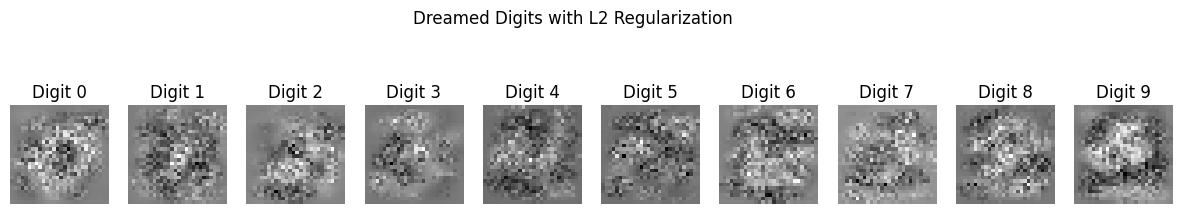

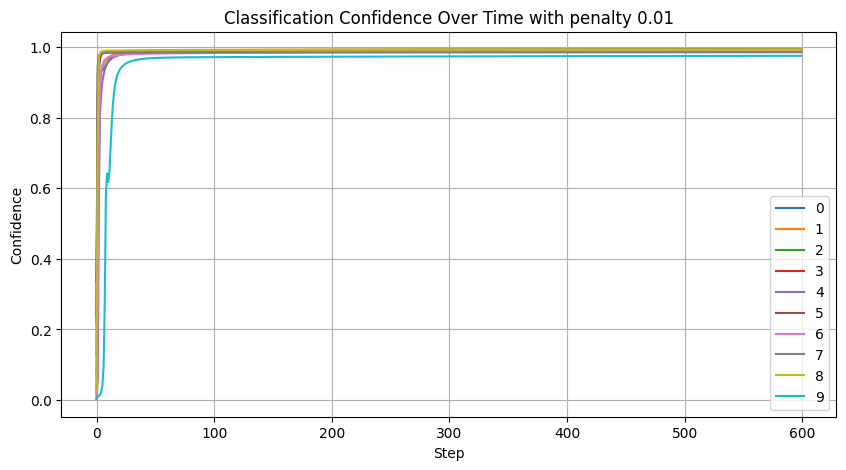

Step 0 | CE Loss: 3.2087 | L2: 1.0050 | Mean Conf: 0.1653
Step 50 | CE Loss: 0.0145 | L2: 0.8805 | Mean Conf: 0.9857
Step 100 | CE Loss: 0.0132 | L2: 0.5268 | Mean Conf: 0.9870
Step 150 | CE Loss: 0.0124 | L2: 0.3344 | Mean Conf: 0.9877
Step 200 | CE Loss: 0.0122 | L2: 0.2216 | Mean Conf: 0.9879
Step 250 | CE Loss: 0.0121 | L2: 0.1526 | Mean Conf: 0.9880
Step 300 | CE Loss: 0.0122 | L2: 0.1094 | Mean Conf: 0.9879
Step 350 | CE Loss: 0.0122 | L2: 0.0821 | Mean Conf: 0.9879
Step 400 | CE Loss: 0.0123 | L2: 0.0646 | Mean Conf: 0.9878
Step 450 | CE Loss: 0.0123 | L2: 0.0533 | Mean Conf: 0.9878
Step 500 | CE Loss: 0.0124 | L2: 0.0459 | Mean Conf: 0.9877
Step 550 | CE Loss: 0.0124 | L2: 0.0411 | Mean Conf: 0.9877
Step 599 | CE Loss: 0.0124 | L2: 0.0380 | Mean Conf: 0.9877


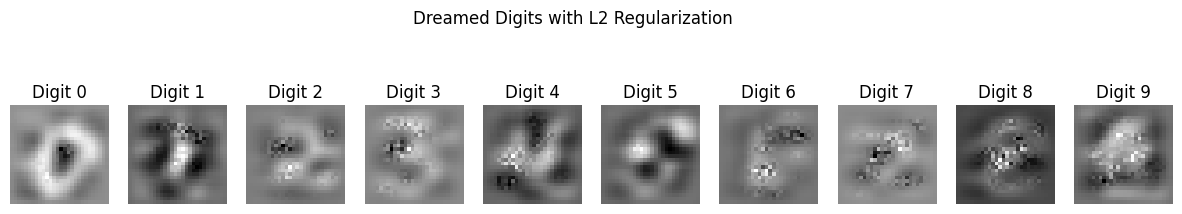

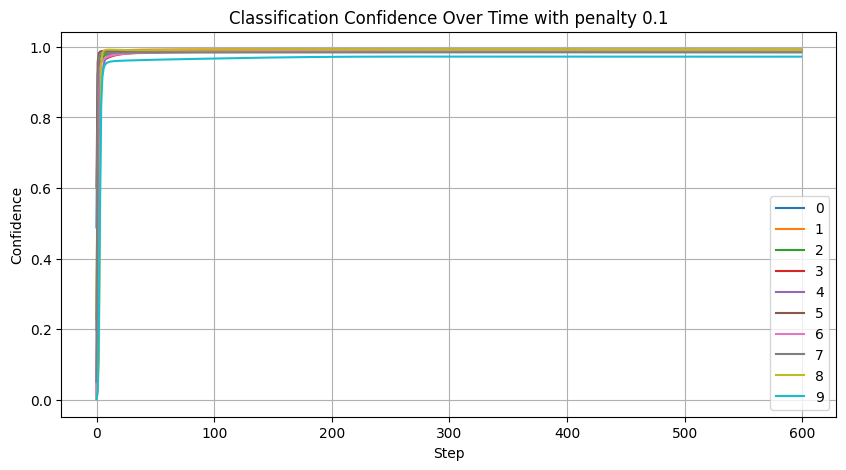

Step 0 | CE Loss: 5.2347 | L2: 0.9869 | Mean Conf: 0.0189
Step 50 | CE Loss: 0.0150 | L2: 0.2317 | Mean Conf: 0.9851
Step 100 | CE Loss: 0.0170 | L2: 0.0406 | Mean Conf: 0.9831
Step 150 | CE Loss: 0.0180 | L2: 0.0179 | Mean Conf: 0.9822
Step 200 | CE Loss: 0.0181 | L2: 0.0146 | Mean Conf: 0.9821
Step 250 | CE Loss: 0.0181 | L2: 0.0139 | Mean Conf: 0.9821
Step 300 | CE Loss: 0.0181 | L2: 0.0138 | Mean Conf: 0.9821
Step 350 | CE Loss: 0.0181 | L2: 0.0138 | Mean Conf: 0.9821
Step 400 | CE Loss: 0.0181 | L2: 0.0138 | Mean Conf: 0.9821
Step 450 | CE Loss: 0.0181 | L2: 0.0138 | Mean Conf: 0.9821
Step 500 | CE Loss: 0.0181 | L2: 0.0138 | Mean Conf: 0.9821
Step 550 | CE Loss: 0.0181 | L2: 0.0138 | Mean Conf: 0.9821
Step 599 | CE Loss: 0.0181 | L2: 0.0138 | Mean Conf: 0.9821


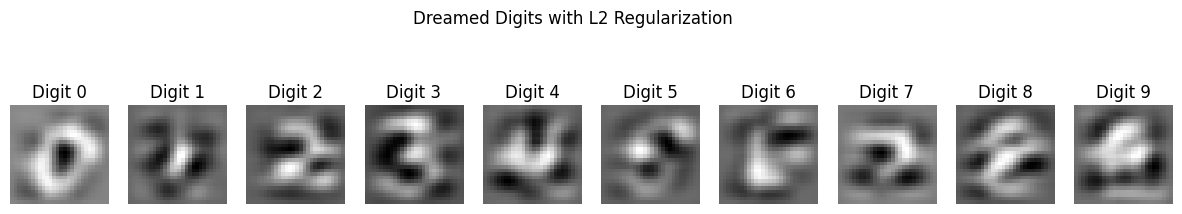

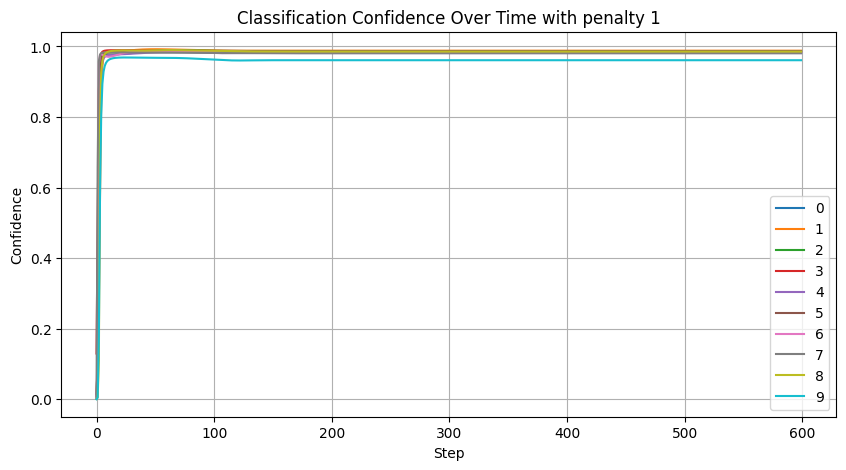

Step 0 | CE Loss: 4.5627 | L2: 0.9930 | Mean Conf: 0.0523
Step 50 | CE Loss: 0.0451 | L2: 0.0106 | Mean Conf: 0.9561
Step 100 | CE Loss: 0.0417 | L2: 0.0068 | Mean Conf: 0.9593
Step 150 | CE Loss: 0.0417 | L2: 0.0067 | Mean Conf: 0.9593
Step 200 | CE Loss: 0.0417 | L2: 0.0067 | Mean Conf: 0.9593
Step 250 | CE Loss: 0.0417 | L2: 0.0067 | Mean Conf: 0.9593
Step 300 | CE Loss: 0.0417 | L2: 0.0067 | Mean Conf: 0.9593
Step 350 | CE Loss: 0.0417 | L2: 0.0067 | Mean Conf: 0.9593
Step 400 | CE Loss: 0.0417 | L2: 0.0067 | Mean Conf: 0.9593
Step 450 | CE Loss: 0.0417 | L2: 0.0067 | Mean Conf: 0.9593
Step 500 | CE Loss: 0.0417 | L2: 0.0067 | Mean Conf: 0.9593
Step 550 | CE Loss: 0.0417 | L2: 0.0067 | Mean Conf: 0.9593
Step 599 | CE Loss: 0.0417 | L2: 0.0067 | Mean Conf: 0.9593


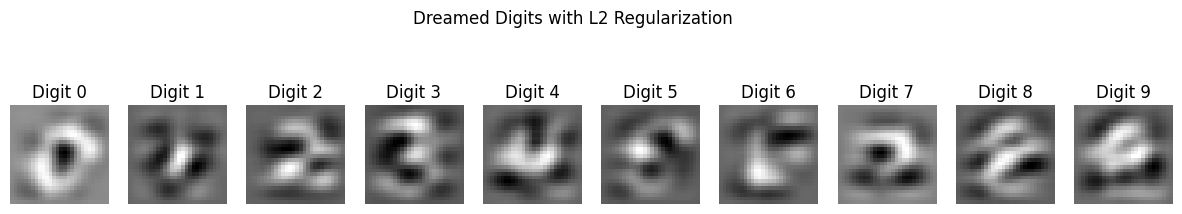

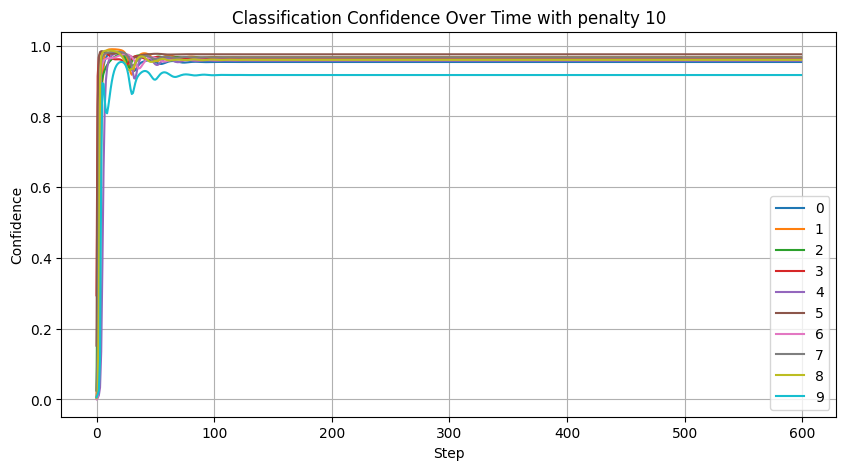

Step 0 | CE Loss: 3.8542 | L2: 1.0446 | Mean Conf: 0.1283
Step 50 | CE Loss: 0.1646 | L2: 0.0059 | Mean Conf: 0.8499
Step 100 | CE Loss: 0.1610 | L2: 0.0034 | Mean Conf: 0.8529
Step 150 | CE Loss: 0.1612 | L2: 0.0033 | Mean Conf: 0.8527
Step 200 | CE Loss: 0.1612 | L2: 0.0033 | Mean Conf: 0.8527
Step 250 | CE Loss: 0.1612 | L2: 0.0033 | Mean Conf: 0.8527
Step 300 | CE Loss: 0.1612 | L2: 0.0033 | Mean Conf: 0.8527
Step 350 | CE Loss: 0.1612 | L2: 0.0033 | Mean Conf: 0.8527
Step 400 | CE Loss: 0.1612 | L2: 0.0033 | Mean Conf: 0.8527
Step 450 | CE Loss: 0.1612 | L2: 0.0033 | Mean Conf: 0.8527
Step 500 | CE Loss: 0.1612 | L2: 0.0033 | Mean Conf: 0.8527
Step 550 | CE Loss: 0.1612 | L2: 0.0033 | Mean Conf: 0.8527
Step 599 | CE Loss: 0.1612 | L2: 0.0033 | Mean Conf: 0.8527


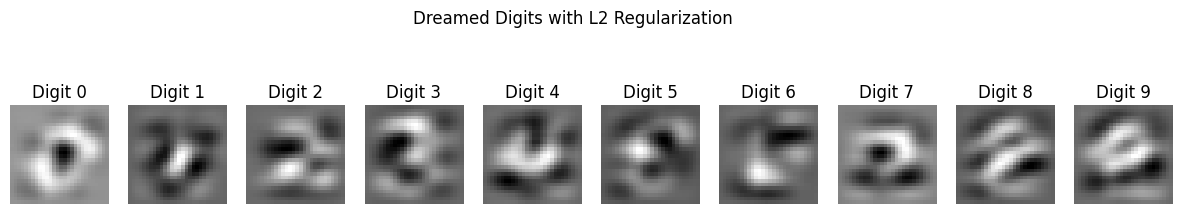

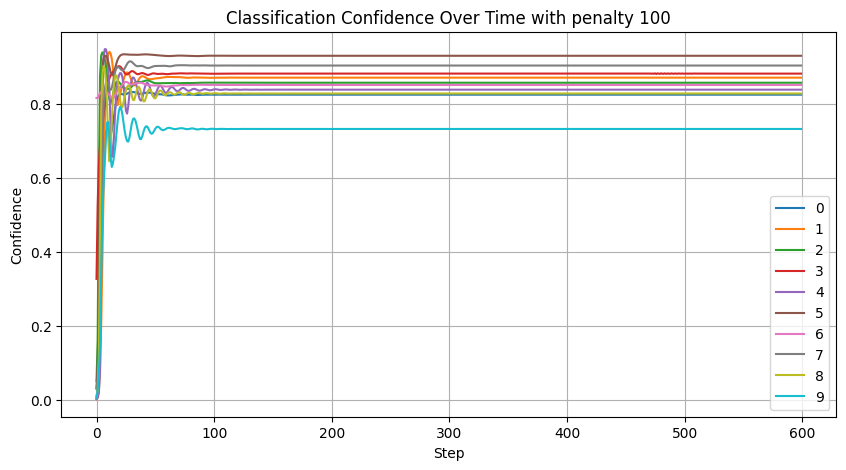

In [8]:
def plot_task3_results(images, history, lambda_l2):

    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap="gray")
        ax.axis("off")
        ax.set_title(f"Digit {i}")
    plt.suptitle("Dreamed Digits with L2 Regularization")
    plt.show()


    history = np.array(history)
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.plot(history[:, i], label=f"{i}")
    plt.title(f"Classification Confidence Over Time with penalty {lambda_l2}")
    plt.xlabel("Step")
    plt.ylabel("Confidence")
    plt.legend()
    plt.grid(True)
    plt.show()
    # test dla różnych kar.
for lam in [0.01, 0.1, 1, 10, 100]:
  final_images, confidence_history = dream_digits_l2(net, lambda_l2=lam)

  plot_task3_results(final_images, confidence_history, lam)

# Adwersaryjna część

In [18]:
def generate_adversarial_example(x, y, model, lambda_l2=0.01, num_steps=200, lr=0.01):

    x = x.clone().detach()
    x = x.to(device)
    y = y.to(device)
    delta = torch.zeros_like(x, requires_grad=True).to(device)

    # Choose a wrong target class
    y_wrong = [i for i in range(10) if i != y.item()]
    y_wrong_tensor = torch.tensor([y_wrong])

    optimizer = torch.optim.Adam([delta], lr=lr)

    for _ in range(num_steps):
        optimizer.zero_grad()

        output = model(x + delta)
        loss = F.cross_entropy(output, y_wrong_tensor) + lambda_l2 * delta.pow(2).mean()

        loss.backward()
        optimizer.step()

        # Optional: clamp to [0, 1] valid pixel range
        delta.data = torch.clamp(x + delta.data, 0, 1) - x

    x_adv = x + delta.detach()
    return x_adv, y_wrong

In [9]:
def show_images(original, adversarial, orig_pred, adv_pred, i):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(original.squeeze(), cmap='gray')
    axs[0].set_title(f'Original (Pred: {orig_pred})')
    axs[1].imshow(adversarial.squeeze(), cmap='gray')
    axs[1].set_title(f'Adversarial (Pred: {adv_pred})')
    for ax in axs:
        ax.axis('off')
    plt.suptitle(f'Example {i}')
    plt.show()

In [19]:
lambda_l2 = 0.01
examples_to_try = 10
success_count = 0

for i, (x, y) in enumerate(testloader):
    if i >= examples_to_try:
        break

    x_adv, y_wrong = generate_adversarial_example(x, y, net, lambda_l2=lambda_l2)

    with torch.no_grad():
        adv_pred = net(x_adv).argmax(dim=1).item()

    if adv_pred != y.item():
        success_count += 1

    show_images(x, x_adv, y.item(), adv_pred, i)
    print(f'True label: {y.item()}, Adv Prediction: {adv_pred}, Success: {adv_pred != y.item()}')

print(f'\nSuccess rate: {success_count / examples_to_try * 100:.2f}%')

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument target in method wrapper_CUDA_nll_loss_forward)